# Bayesian Statistical Inference: IV

*S. R. Taylor (2024)*

Material in this lecture and notebook is based upon the lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference2" lecture of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), Karen Leighly's [Bayesian Stats](http://seminar.ouml.org/lectures/bayesian-statistics/), and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

---

## Contents
* [Practical MCMC](#one)
* [MCMC Parameter Estimation In The Wild](#two)
* [MCMC With Emcee](#three)
* [MCMC With PyMC3](#four)
* [MCMC With The PTMCMCSampler](#five)

---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

***In case you didn't do it last time:*** Please pause for a few minutes and install these packages `emcee`, `pymc3`, and `PTMCMCSampler` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn.

In [1]:
!pip3 install emcee

In [2]:
!pip3 install pymc

In [6]:
!pip3 install git+https://github.com/dfm/acor@master

  Cloning https://github.com/dfm/acor (to revision master) to /private/var/folders/j3/1wfcykhx07bcnpbjshp_sztr0000gp/T/pip-req-build-761mo4fr
  Running command git clone --filter=blob:none --quiet https://github.com/dfm/acor /private/var/folders/j3/1wfcykhx07bcnpbjshp_sztr0000gp/T/pip-req-build-761mo4fr
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  branch 'master' set up to track 'origin/master'.
  Resolved https://github.com/dfm/acor to commit b55eb8efa7df6c73b6f3f0c9b64fa1c801e8f821
  Preparing metadata (setup.py) ... done


In [7]:
!pip3 install git+https://github.com/jellis18/PTMCMCSampler@master

  Cloning https://github.com/jellis18/PTMCMCSampler (to revision master) to /private/var/folders/j3/1wfcykhx07bcnpbjshp_sztr0000gp/T/pip-req-build-j7s4q2e6
  Running command git clone --filter=blob:none --quiet https://github.com/jellis18/PTMCMCSampler /private/var/folders/j3/1wfcykhx07bcnpbjshp_sztr0000gp/T/pip-req-build-j7s4q2e6
  Resolved https://github.com/jellis18/PTMCMCSampler to commit 98110732aa5b031daab254f3abefc4b80fda4487
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Practical MCMC <a class="anchor" id="one"></a>

In [8]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [ ]:
<!-- ### Practical MCMC chain checks

1. **CHECK ACCEPTANCE:** some MCMC samplers give an updating estimate of the current acceptance rate of new samples. Ideally for a sampler using some form of Metropolis-Hastings, this should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve.

    - If the acceptance rate is high, the chain is moving but might not be exploring well. This gives high acceptance rate but poor global exploration of the posterior surface.
    
    - If the acceptance rate is low, the chain is hardly moving meaning that it's stuck in a rut or trying to jump to new points that are too far away.
    

2. **CHECK TRACEPLOTS:** After getting an idea of the acceptance rate, make traceplots of your chain. Ideally, our tracplot in each parameter would be mixing well (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. This will tell you whether your chain is getting stuck or encountering inefficiencies.


3. **CHECK AUTOCORRELATION LENGTH:** The MCMC chain with Metropolis-Hastings will not give fully-independent random samples. The next point is influenced by where the previous point was. We need to check how much to down-sample the chain so that the points lack memory and influence from others. This is given by the ***autocorrelation length***. 


Look again at the plots below for an arbitrary problem (my own image). The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples. Familiarize yourself with the kind of inspections needed for MCMC chains.

- **In the top row, the proposal width was too small**. 
- **In the middle row, the proposal width was too big**. 
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**

![](./figures/fig_taylor_mcmc.png) -->

The next several cells will load up videos from `Vimeo` to demonstrate how Metropolis-Hastings--based MCMC samples (i) a square region, (ii) a diagonal region, (iii) a cross-diagonal region, and finally... (iv) a banana. Because if you can't sample from a banana then what's the use of your MCMC? Execute the cells and watch through them all.

In [10]:
from IPython.display import HTML
HTML('<iframe src="https://player.vimeo.com/video/19274900" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274900">Metropolis in the Square</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

In [11]:
HTML('<iframe src="https://player.vimeo.com/video/19274173" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274173">Metropolis in Diagonal Region</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

In [12]:
HTML('<iframe src="https://player.vimeo.com/video/19275365" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274173">Metropolis in Diagonal Region</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

In [13]:
HTML('<iframe src="https://player.vimeo.com/video/22616409" width="640" height="480" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/19274173">Metropolis in Diagonal Region</a> from <a href="https://vimeo.com/user3812935">Abraham Flaxman</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

### Optimizing sampling

There are several ways of improving the way we propose new sample locations in Metropolis-Hastings. Here are a few.

#### (a) Adaptive Metropolis (AM)

In AM you use the **empirically-estimated parameter covariance matrix to tune the width of the Gaussian proposal  distribution**. Tuning is updated during the sampling in order to reach optimal mixing. In practice this  means  that  one  uses  the  entire  past  history  of  the  chain  up  until  the  current point to estimate the parameter covariance matrix, scaling this covariance matrix by $\alpha= 2.38^2/N_\mathrm{param}$ to reach the optimal $\sim25\%$ proposal acceptance rate. 

Practically speaking, the procedure is
- Estimate the $N_\mathrm{param}\times N_\mathrm{param}$ parameter covariance matrix, $C$, using all samples. Standard numpy or scipy algorithms can do this. 
- Factorize the matrix using a Cholesky algorithm, such that $C = L L^T$.
- Draw a new proposed point such that $y = x_i + \sqrt{\alpha} Lu$, where $x_i$ is the current point, and $u$ is an $N_\mathrm{param}$-dimensional vector of random draws from a zero-mean unit-variance Gaussian.

*One subtlety here is that by using more than just the most recent point to tune the sampling, our chain is no longer Markovian. This is easily resolved by allowing the chain to pass through a proposal tuning stage using AM, after which the proposal covariance matrix is frozen so that the chain is Markovian then on.*

#### (b) Single Component Adaptive Metropolis (SCAM)

With high-dimensional model parameter spaces, or even target posterior distributions with significant covariances amongst some parameters, the AM method may suffer from low acceptance rates. One method that addresses this is a variant on AM called Single Component Adaptive Metropolis (SCAM).  **This  involves  jumping  along selected eigenvectors (or principal axes) of the parameter covariance matrix**, whichis equivalent to jumping in only one uncorrelated parameter at a time. (We'll see more of principal axes later in the course)

- We take our parameter covariance matrix as in AM, but this time work out the eigenvalues and eigenvectors, $C = D\Lambda D^T$, where $D$ is a unitary matrix with eigenvectors as columns, and $\Lambda = \mathrm{diag}(\sigma^2_\Lambda$) is a diagonal matrix of eigenvalues. 
- A SCAM jump corresponds to a zero-mean unit-variance jump in a randomly chosen uncorrelated parameter, equivalent to jumping along one of the eigenvectors. 
- A proposal draw is given by $y = x_i+ 2.4 D_j u_j$, where $D_j$ is a randomly chosen column of D corresponding to the $j$th eigenvector of $C$, and $u_j \sim \mathcal{N}(0,\sigma^j_\Lambda)$.

#### (c) Differential Evolution (DE)

Another popular proposal scheme is DE, which is a simple *genetic algorithm* that treats the past history of the  chain up until the current point as a population. 

- In DE, you choose two random points from the chain’s history to construct a difference vector along which the chain can jump. 
- A DE proposal draw is given by $y = x_i + \beta(x_{r1} − x_{r2})$, where $x_{r1,2}$ are parameter vectors from two randomly chosen points in the past history of the chain, and $\beta$ is a scaling factor that is usually set to be the same as the AM scaling factor, i.e., $2.38 / \sqrt{N_\mathrm{param}}$.


#### The Full Proposal Cocktail

Real world MCMC should use a cocktail of proposal schemes, aimed at ensuring convergence to the target posterior distribution with **minimal burn-in**, **optimal acceptance rate**, and as **short an autocorrelation length** as possible. 

At each MCMC iteration the proposed parameter location can be drawn according to a weighted list of schemes, involving **(i) AM, (ii) SCAM, (iii) DE, (iv) empirical proposal distributions (e.g. from previous analyses), and finally (iv) draws from the parameter prior distribution**. 

The final prior-draw scheme allows for occasional large departures from regions of high likelihood, ensuring that we are exploring the full parameter landscape well, and avoiding the possibility of getting stuck in local maxima. 

Really, you can use any reasonable distribution you like to propose points. Your only constraint is to ensure that detailed balance is maintained through the relevant transition weightings in  the  Metropolis-Hastings ratio, $p_\mathrm{acc}$.

##  MCMC Parameter Estimation In The Wild <a class="anchor" id="two"></a>

Let's look at some more involved examples. We will use two popular python modules: `emcee` and `PyMC`. I'll also show you a great but less used sampler that is the standard one for my field of PTA gravitational-wave astrophysics: `PTMCMCSampler`. Quoting Jake VanderPlas for `emcee` and `PyMC`: 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

> The emcee package (*also known as MCMC Hammer, which is in the running for best Python package name in history*) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".

Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC

> The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*

More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/), but note that we are going to be using [PyMC3](https://docs.pymc.io/).

### PTMCMCSampler

> This is a bare-bones sampler, requiring only that the user provide a log-likelihood function and a log-prior function. The user can change the relative amounts of AM, SCAM, and DE being used to propose new points to jump to. The great thing about this sampler is that one can add new custom proposal schemes according to the user's preference. 

> Also, this sampler implements **parallel tempering MCMC (PTMCMC)**. We won't go into detail about this, but suffice it to say that multiple copies of the MCMC are run in parallel, where the copies actually sample from different roots of the likelihood. The higher roots we take, the more the likelihood is flattened out, making it easier to sample. These "rooted" chains then communicate back to the main chain, improving exploration of the parameter space. All these chains can actually be post-processed to get the Bayesian evidence too, in a scheme called **thermodynamic integration**.

##  MCMC with emcee <a class="anchor" id="three"></a>

Import `emcee` and generate some homoescedastic Gaussian data. We'll assume the standard deviation is know, so we're only estimating $\mu$.

In [14]:
import emcee

np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Define all the relevant functions.

In [15]:
def Likelihood(x, sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2 /2 /sigma**2))

def Prior(x):
    return 1.0 / 10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data) * Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

`emcee` combines multiple "walkers", each of which is its own MCMC chain. The number of trace results will be nwalkers $\times$ nsteps.

In [16]:
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")

done


In [17]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned and flattened chain

(6, 5000, 1)
(24000, 1)


Text(0.5, 1.0, 'Chain from emcee')

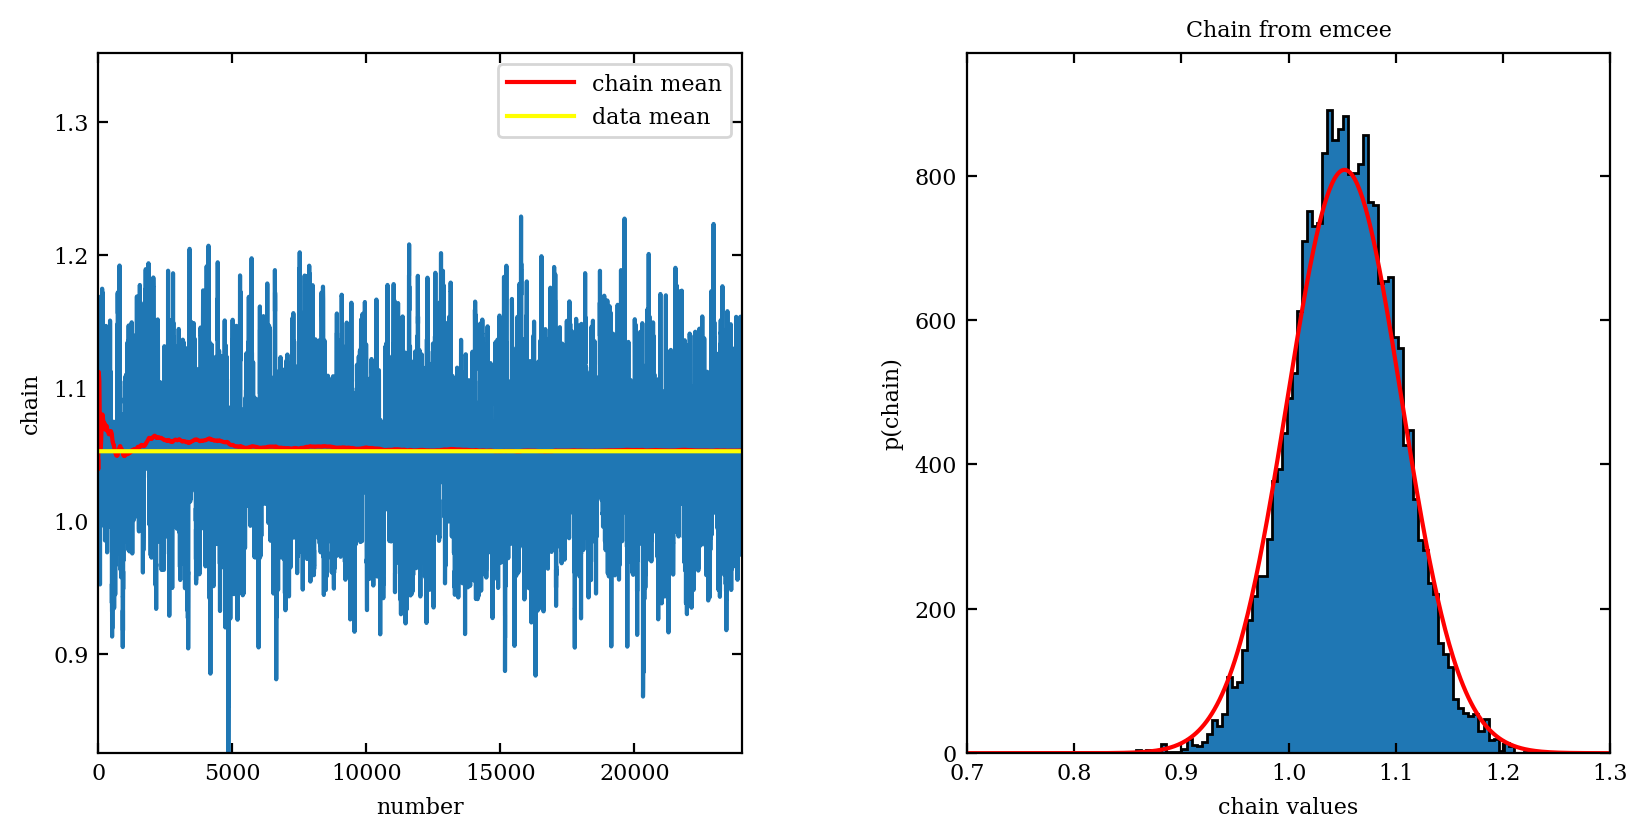

In [18]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, 
                    wspace=0.35, bottom=0.18)

chainE = emcee_trace #[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1, M, M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')

# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC, c='red', label='chain mean') 
ax1.plot(xgrid, 0*xgrid + np.mean(data),
         c='yellow',label='data mean')
ax1.legend()

ax2 = fig.add_subplot(122)
# skip first burn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>burn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], 
                                bins='auto', histtype='stepfilled')

# plot expectations based on central limit theorem
binwidth = bins[1] - bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain * binwidth * stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 

ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee')

##  MCMC with PyMC3 <a class="anchor" id="four"></a>

Now we will use pyMC3 to get a 2-dimensional posterior pdf for location and scale parameters using a sample drawn from a **Cauchy distribution**. Remember a Cauchy distribution formally has no mean or standard deviation because its tails fall off shallower than $1/x^2$.

The following is code adapted from Figure 5.22 of the textbook. Initially, we load in `PyMC3` and define the Cauchy log likelihood. 

***NOTE:*** The code here for the Cauchy likelihood is actually only for when we look at the analytic estimate, since `PyMC3` has ready-made modules for many standard functions!

In [19]:
from scipy.stats import cauchy
import pymc as pm

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

Generate some data from the Cauchy distribution.

In [20]:
# ----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

Set up the `PyMC3` model.

In [21]:
# ----------------------------------------------------------------------
# Set up and run MCMC:
with pm.Model():
    mu = pm.Uniform('mu', -5, 5) #uniform in Cauchy mu
    log_gamma = pm.Uniform('log_gamma', -10, 10) #uniform in log of Cauchy gamma

    # set up our observed variable x
    # i.e. read this as 'x is distributed as a Cauchy variable'
    x = pm.Cauchy('x', mu, np.exp(log_gamma), observed=xi)

    trace = pm.sample(draws=12000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, log_gamma]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


You may have seen some output messages along the lines of "Auto-assigning NUTS sampler...". `PyMC3` is very sophisticated, and will automatically decide for you the best tools for the job. 

In this case, it decided you needed **No-U-Turn Hamiltonian gradient-based sampling**, where gradient information about the Cauchy likelihood helped in the exploration of parameter space. 

In [23]:
np.array(trace.posterior['mu']).flatten()

array([ 0.02888419, -0.5473814 , -0.18134042, ..., -0.22290257,
        0.50784603,  0.29978195])

In [24]:
# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(np.array(trace.posterior['mu']).flatten(),
                                             np.exp(np.array(trace.posterior['log_gamma'])).flatten(),
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

# ----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(np.array(trace.posterior['mu']).flatten(), 
                                bins=mu_bins, density=True)
hist_gamma, bins_gamma = np.histogram(np.exp(np.array(trace.posterior['log_gamma'])).flatten(),
                                      bins=gamma_bins, density=True)

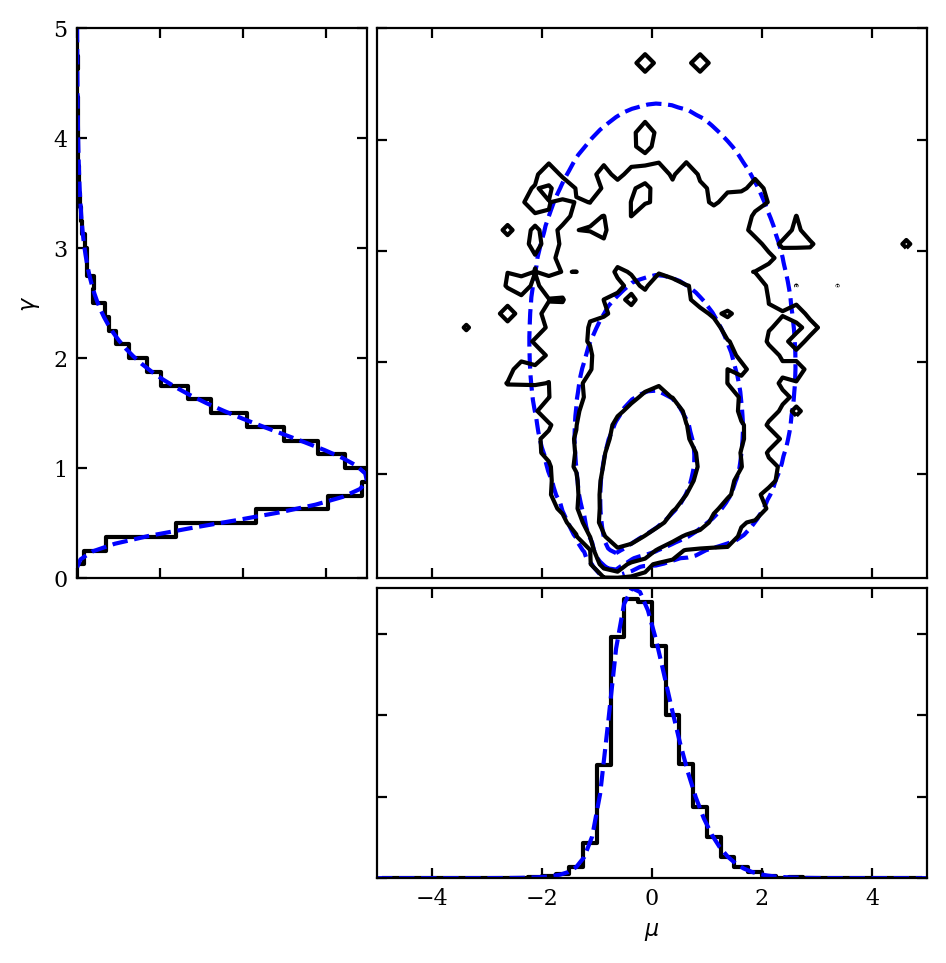

In [25]:
# ----------------------------------------------------------------------
# plot all the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

The resulting $2$D joint posterior pdf corner plot shows analytic results as blue dashed lines, and MCMC sampling results as black contours.

## MCMC With The PTMCMCSampler <a class="anchor" id="five"></a>

Let's now explore the more bare-bones sampler. This helps to expose a lot of what is going on in the other samplers, where it's difficult to see what happens under the hood.

**We're going to analyze a homoescedastic Gaussian dataset, but this time search over the mean and standard deviation with our MCMC.**

In [26]:
# don't worry about any warning messages regarding mpi4py
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Optional mpi4py package is not installed.  MPI support is not available.


In [27]:
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

Fill in the function below to create a prior function that is the multiplication of a uniform prior for the mean over $0.5$ to $1.5$, and a uniform prior for the standard deviation between $0.1$ and $0.9$. 

The priors are separable and independent, so the overall prior should be the product of the prior for each parameter.

In [31]:
def Likelihood(x, data):
    # Gaussian likelihood 
    return np.prod(stats.norm(loc=x[0], scale=x[1]).pdf(data))

def Prior(x):
    # create a uniform prior in mu and sigma
    return 0.75  

def logLikelihood(x):
    return np.log(Likelihood(x, data))

def logPrior(x):
    return 0.5 * np.log(Prior(x))

In [32]:
# dimension of parameter space
ndim = 2

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logLikelihood, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

Start sampling!

In [33]:
# sampler for N steps
N = int(3e4)
x0 = np.array([0.9, 0.3])
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 33.33 percent in 3.054160 s Acceptance rate = 0.536644Adding DE jump with weight 50
Finished 100.00 percent in 9.066930 s Acceptance rate = 0.608367
Run Complete


In [35]:
# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')
chain

array([[   0.9       ,    0.3       , -142.377617  , -142.233776  ,
           0.        ,    1.        ],
       [   0.9       ,    0.31057616, -134.411926  , -134.268085  ,
           0.849     ,    1.        ],
       [   0.94766361,    0.328293  , -117.551664  , -117.407823  ,
           0.849     ,    1.        ],
       ...,
       [   1.06065522,    0.59226432,  -80.171857  ,  -80.028016  ,
           0.608367  ,    1.        ],
       [   0.99941437,    0.59553376,  -80.661654  ,  -80.517813  ,
           0.608367  ,    1.        ],
       [   0.90108484,    0.5542306 ,  -82.991983  ,  -82.848142  ,
           0.608367  ,    1.        ]])

Ignore the final 4 columns in your chain array. Those are chain diagnostics, not parameters.

<font color='red'>OK, now that you have your chain, it's up to you to diagnose it.</font>
    
- Make traceplots in both $\mu$ and $\sigma$. 
- Discuss when you should cut off burn-in. 
- Compute the autocorrelation length of the chain, and down-sample it to select only points every autocorrelation length. 
- Finally, make a corner plot that has labels, shows titles, and has $68\%$ and $95\%$ quantiles and levels.

In [75]:
# xgrid = np.linspace(start=0,stop=4,num=len(chain[0]))
# plt.loglog(xgrid,chain)

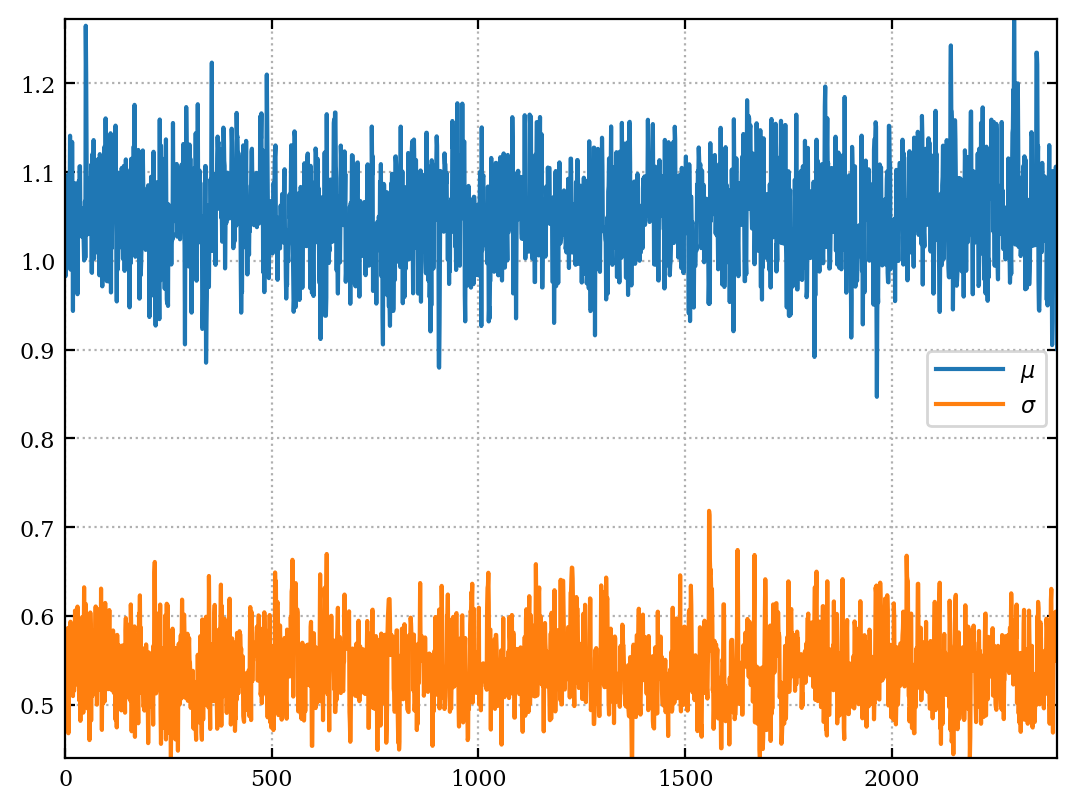

In [139]:
data = chain[0:,0]
noise = chain[0:,1]

tdata = data[600:]
tnoise = noise[600:]

plt.plot(tdata,label='$\mu$')
plt.plot(tnoise,label='$\sigma$')
plt.legend(loc='best')
plt.grid()

I cutt of burn in when the points in the traceplot relatively oscilate between roughly the same mean 

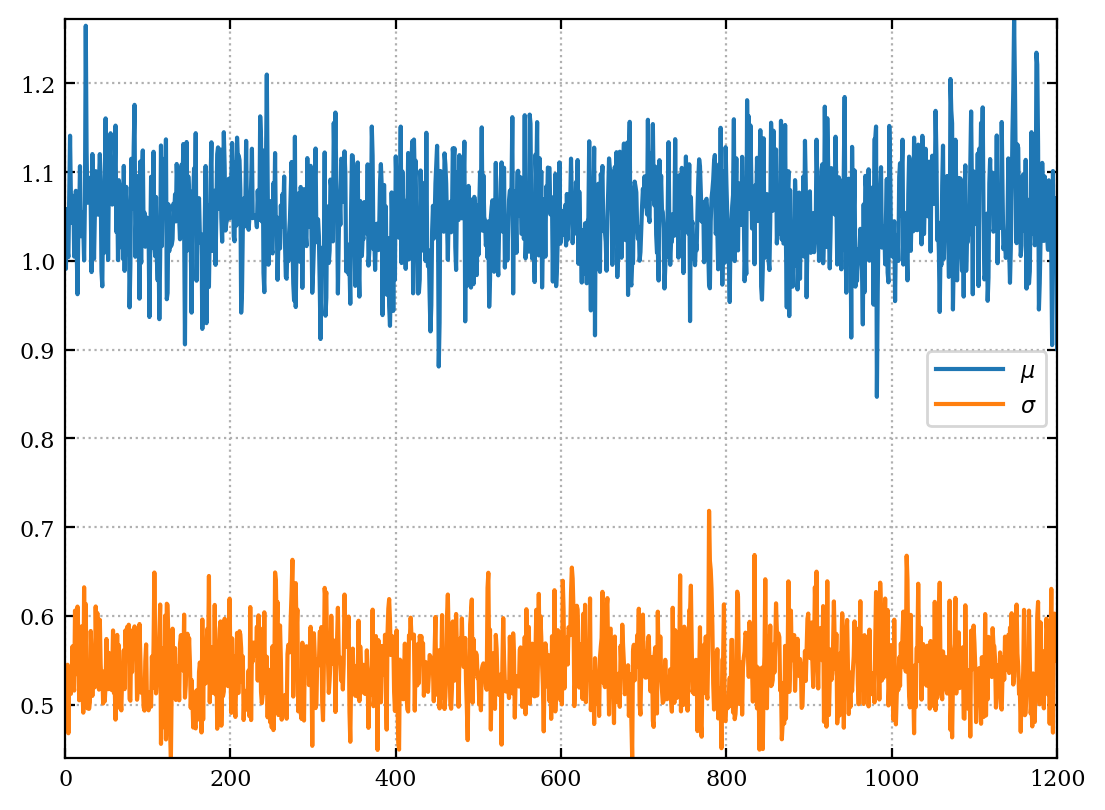

In [145]:
import acor
ancor = acor.acor(tdata)
dsample = np.array(tdata[::int(np.round(ancor[0],0))])
dnoise = np.array(tnoise[::int(np.round(ancor[0],0))])

plt.plot(dsample,label='$\mu$')
plt.plot(dnoise,label='$\sigma$')
plt.legend(loc='best')
plt.grid()
# the first element of the tuple is the length between independent samples.
# thin by the nearest integer.

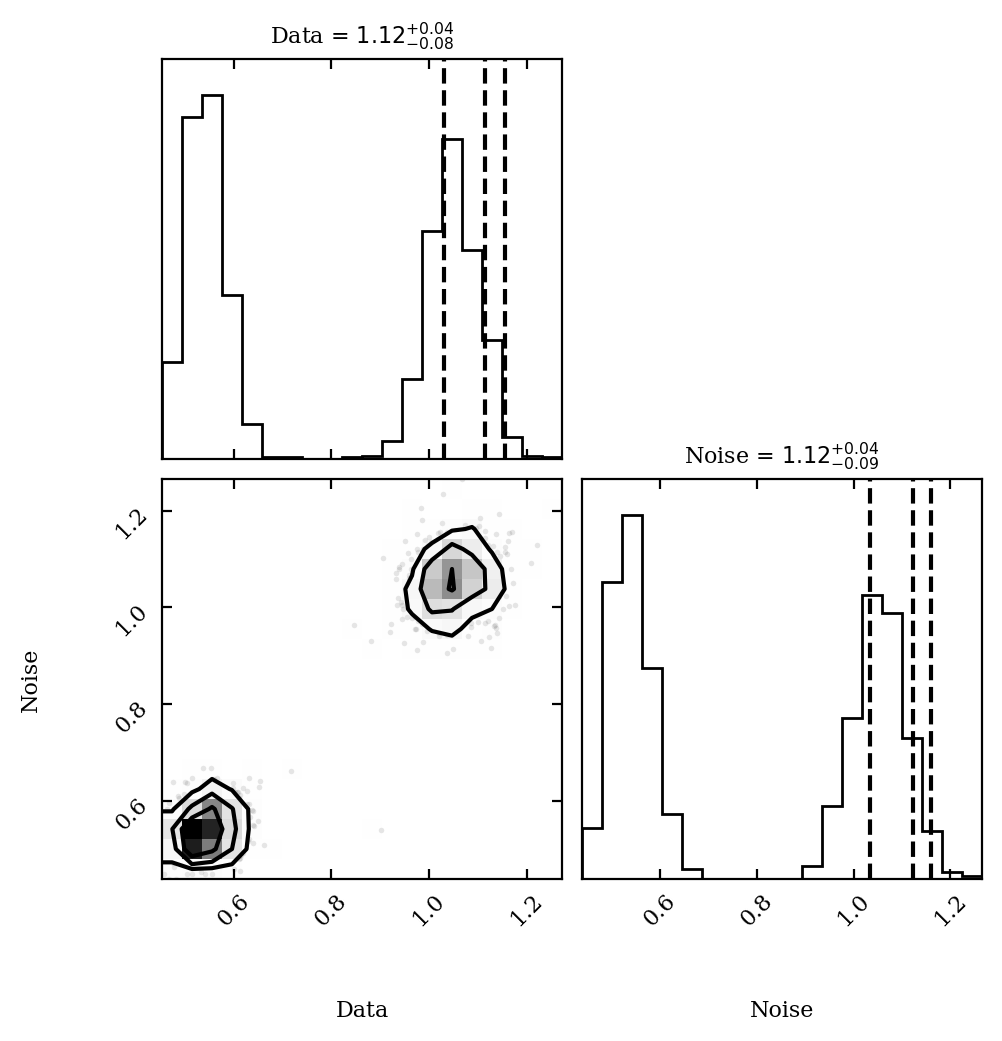

In [174]:
import corner
arr = np.array([dsample,dnoise])
Arr = np.reshape(arr,(len(dnoise),2))

figure = corner.corner(
    Arr,
    labels = ['Data','Noise'],
    quantiles=[0.68, 0.95,0.99],
    show_titles=True
)

In [144]:
dsample

dtype('float64')

In [153]:
samples.shape

(10000, 2)

In [157]:
Arr.shape

(2, 1201)

In [158]:
arr = np.reshape(Arr,(len(dnoise),2))
arr

array([[1.04405667, 0.99110555],
       [1.058534  , 1.01158385],
       [1.0043446 , 1.07193415],
       ...,
       [0.46849099, 0.57272919],
       [0.60259248, 0.54953749],
       [0.59226432, 0.5542306 ]])